# Training Tests

This notebook contains some experiments for using machine learning to classify pixels as lane or not-lane.

The idea was to prevent having to hand tune thresholds. Ultimatly I had better luck hand tuning cutoffs, but I found the ideas
I exercised here interesting, at least.

In [1]:
""" Imports """

import glob
import cv2
import time
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

%matplotlib inline 

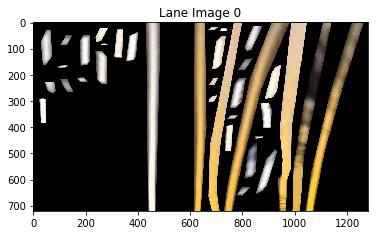

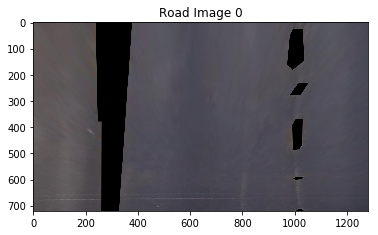

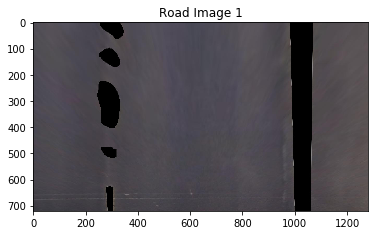

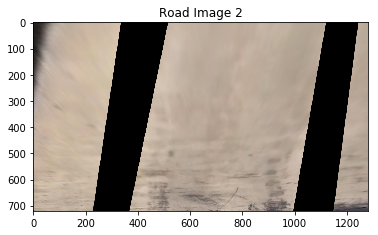

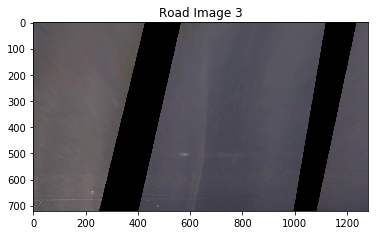

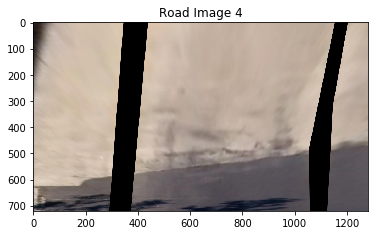

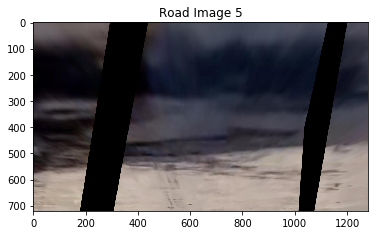

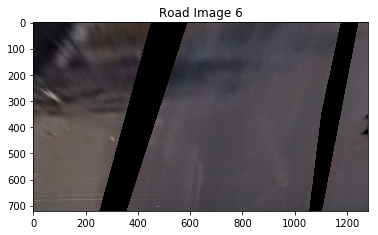

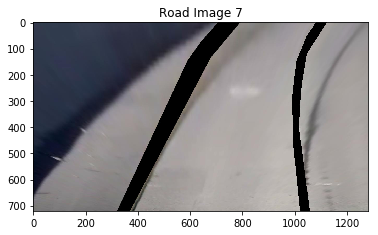

In [2]:
""" Load images. 

There are two data sets, the lane images (only has pixels of lane lines) and road images (only has pixels from the road).
Black pixels are not considered.
"""

# Load lane images
lane_img_files = glob.glob('../data/train/lanes/*.jpg')
lane_imgs = [plt.imread(f) for f in lane_img_files]

for i, img in enumerate(lane_imgs):
    plt.figure()
    plt.imshow(img)
    plt.title('Lane Image {}'.format(i))

# Load road images
road_img_files = glob.glob('../data/train/road/*.jpg')
road_imgs = [plt.imread(f) for f in road_img_files]

for i, img in enumerate(road_imgs):
    plt.figure()
    plt.imshow(img)
    plt.title('Road Image {}'.format(i))

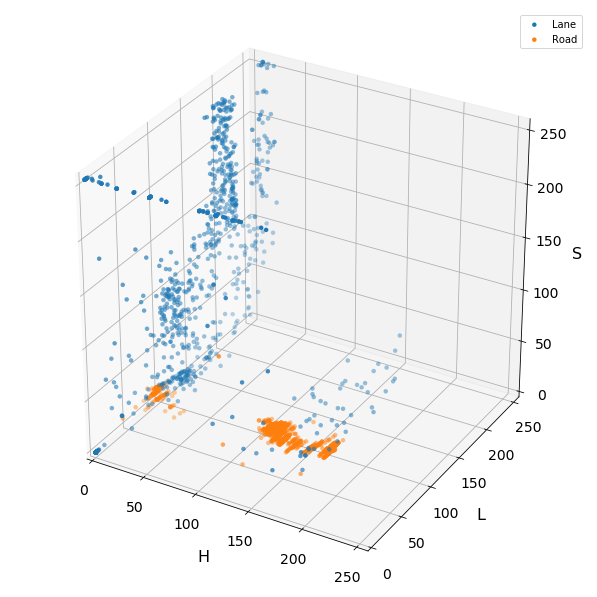

In [3]:
""" Lane vs Road color space comparison.

By changing the parameters of `plot3d_compare()` you can compare the color space of any pair of lane image and road image
in any color space.

Note: This does not ignore the black pixels. The estimator will.
"""

def subsample(img, cspace='RGB'):
    if cspace != 'RGB':
        if cspace == 'HSV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'LAB':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    else:
        img = np.copy(img)
    scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
    img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)
    return img_small

def plot3d_compare(img1, img2, name1, name2, space='RBG', axis_limits=[(0, 255), (0, 255), (0, 255)]):
    pixels1 = subsample(img1, space)
    pixels2 = subsample(img2, space)
    
    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(space[0], fontsize=16, labelpad=16)
    ax.set_ylabel(space[1], fontsize=16, labelpad=16)
    ax.set_zlabel(space[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels1[:, :, 0].ravel(),
        pixels1[:, :, 1].ravel(),
        pixels1[:, :, 2].ravel(), edgecolors='none')
    ax.scatter(
        pixels2[:, :, 0].ravel(),
        pixels2[:, :, 1].ravel(),
        pixels2[:, :, 2].ravel(), edgecolors='none')
    ax.legend([name1, name2])

    return ax  # return Axes3D object for further manipulation


# Plot and show
plot3d_compare(lane_imgs[0], road_imgs[0], 'Lane', 'Road', 'HLS')

# Train Estimator 

This trains a SVM to identify lanes pixel-by-pixel from 3-channel color intensity only.
THIS TAKES A LONG TIME! Exponentially so as you increase `factor_reduce_notlane`. We really should be sampling the images and then training from that.


In [4]:
""" Get features """

def extract_features(imgs, cspace='RGB'):
    features = []
    for i, image in enumerate(imgs):
        print('Getting image', i, 'features...')
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'LAB':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        else:
            feature_image = np.copy(image)
        
        for row in feature_image:
            for xyz in row:
                if xyz[0] == 0 and xyz[1] == 0 and xyz[2] == 0:
                    continue
                features.append(xyz)
    return features

# Parameters
cspace = 'HSV'
factor_reduce_notlane = 3  # notlane will be factor times the size of lane

# Read in car and non-car images
lane = lane_imgs
notlane = road_imgs
print('Num lane imgs:', len(lane))
print('Num not-lane imgs:', len(notlane))

# Get features
print('\nFinding features for the', cspace, 'color space:')
lane_features = extract_features(lane, cspace=cspace)
notlane_features = extract_features(notlane, cspace=cspace)

print('\nNum lanes samples (pixels)', len(lane_features))
print('Num not-lane samples:', len(notlane_features))

print('Reducing not-lane set size')
notlane_features_balanced = []
for i in range(len(notlane_features)):
    if i % ((len(notlane_features)) // len(lane_features)) // factor_reduce_notlane == 0:
        notlane_features_balanced.append(notlane_features[i])
notlane_features = notlane_features_balanced
print('Num not-lane samples is now:', len(notlane_features))

# Features vector
X = np.vstack((lane_features, notlane_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Labels vector
y = np.hstack((np.ones(len(lane_features)), np.zeros(len(notlane_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.4, random_state=rand_state)

print('\nTotal number of samples:', len(X))
print('Training samples:', len(X_train))
print('Test samples:', len(X_test))
print('Feature vector length:', len(X_train[0]))

Num lane imgs: 1
Num not-lane imgs: 8

Finding features for the HSV color space:
Getting image 0 features...
Getting image 0 features...
Getting image 1 features...
Getting image 2 features...
Getting image 3 features...
Getting image 4 features...
Getting image 5 features...
Getting image 6 features...
Getting image 7 features...

Num lanes samples (pixels) 322045
Num not-lane samples: 6402537
Reducing not-lane set size
Num not-lane samples is now: 1010928

Total number of samples: 1332973
Training samples: 799783
Test samples: 533190
Feature vector length: 3


In [5]:
""" Train SVM 
As notes above, this can take exponentially longer depending on your `factor_reduce_notlane`.
"""

# Use a linear SVC
print('\nTraining with SVC')
svc = LinearSVC()
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round((t2-t)/60, 1), 'minutes used to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


Training with SVC
2.9 minutes used to train SVC...
Test Accuracy of SVC =  0.8847


# Run Estimator

C:\Users\Peter\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


0.06605 Seconds to predict classify one image of pixels with SVC
0.07005 Seconds to predict classify one image of pixels with SVC
0.10457 Seconds to predict classify one image of pixels with SVC
0.07355 Seconds to predict classify one image of pixels with SVC
0.06204 Seconds to predict classify one image of pixels with SVC
0.06005 Seconds to predict classify one image of pixels with SVC
0.06875 Seconds to predict classify one image of pixels with SVC
0.06055 Seconds to predict classify one image of pixels with SVC
0.06154 Seconds to predict classify one image of pixels with SVC
0.05954 Seconds to predict classify one image of pixels with SVC
0.06705 Seconds to predict classify one image of pixels with SVC
0.06205 Seconds to predict classify one image of pixels with SVC
0.07406 Seconds to predict classify one image of pixels with SVC
0.06004 Seconds to predict classify one image of pixels with SVC
0.07606 Seconds to predict classify one image of pixels with SVC
0.08306 Seconds to predic

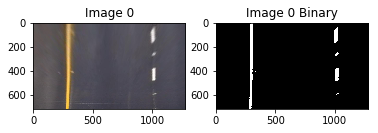

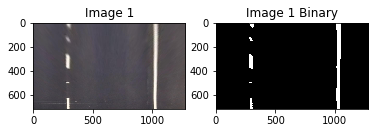

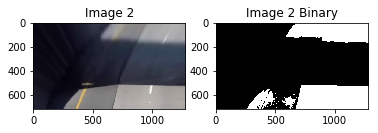

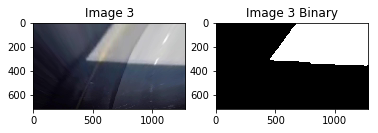

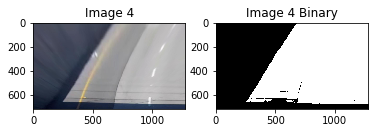

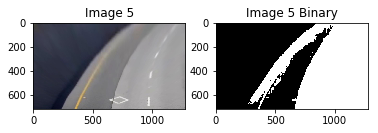

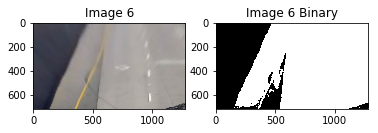

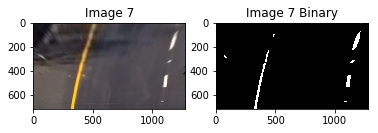

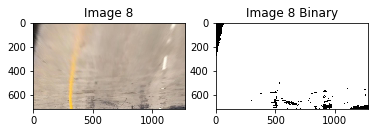

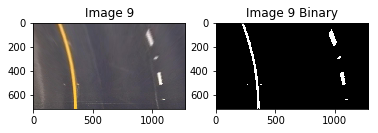

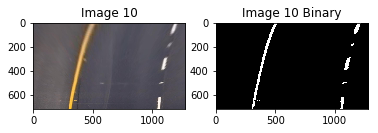

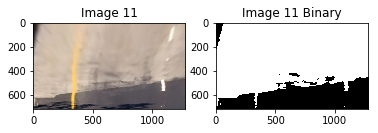

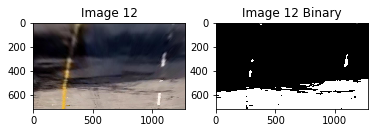

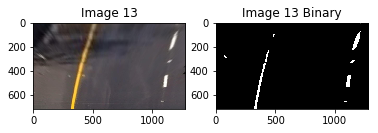

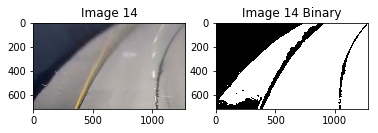

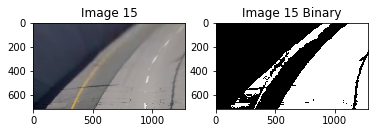

In [6]:
""" Test the SVC on the origonal and challenge dataset. """

def svc_test(test_imgs, name):
    for i, im in enumerate(test_imgs):
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.title('{} {}'.format(name, i))
        plt.imshow(im)

        t=time.time()
        img = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)
        img = np.copy(im)
        mask = np.zeros(img.shape[0:2])

        img_h, img_w = mask.shape

        mask = svc.predict(X_scaler.transform(img.reshape((img_h*img_w, 3))))
        mask = mask.reshape((img_h, img_w))

        t2 = time.time()
        print(round(t2-t, 5), 'Seconds to predict classify one image of pixels with SVC')

        plt.subplot(1, 2, 2)
        plt.title('{} {} Binary'.format(name, i))
        plt.imshow(mask, cmap='gray')

img_files = glob.glob('../data/threshold_test_imgs/*.jpg')
imgs = [plt.imread(f) for f in img_files]
        
# Origonal images
svc_test(imgs, 'Image')